# Follow the Average Numpy Model

## Overview
The following code implements a FTA model, as developed by Hammond and Ornstein. Unlike most ABMs, this code abandons the use of class structures (to organize agents, environments, update rules, etc...) and instead uses matrices to perform an algorithmic reduction of the FTA computation. By solely using matrices this implementation is able to achieve high performance by sourcing all computationally expensive operations to the `numpy` library which is written in C.

## The Math
Let's start representing all agents BMIs in a vector (denoted as $\textbf{b}$, for BMI) where the i-th element in the vector is the i-th agent's BMI. We will also represent the network connections between agents with an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) (denoted as $\textbf{A}$, for adjacency). For every step of the model we will want to calculate the average BMI of each agent's neighbors. To do so, consider what happens when we matrix multiply $\textbf{b}$ with $\textbf{A}$:

$$ \textbf{b}^T \textbf{A} = [\textbf{b} \cdot \textbf{A}_{*1}, ...,  \textbf{b} \cdot \textbf{A}_{*n}]$$

Here $\textbf{A}_{*i}$ is the i-th row (or column, because the network is undirected) of $\textbf{A}$. Then the i-th element of the resulting vector is:

$$(\textbf{b}^T \textbf{A})_i = \Sigma _{j=1} \textbf{b}_j \cdot \textbf{A}_{ij}$$

If we look closely at this it is actually just the sum of all neighbors BMIs for the i-th agent! So all we have to do is divide by the number of neighbors for agent i to get the average. Finding the number of neighbors for any i-th agent can easily be found by summing either the rows or columns of $\textbf{A}$ to get a vector (denoted as $\textbf{c}$, for count) of the number of neighbors connected to each agent. So the mean BMI of each agents neighbors (denoted as $\overline{\textbf{b}}$) can be calculated as follows:

$$\overline{\textbf{b}} = \frac{\textbf{b}^T \textbf{A}}{\textbf{c}}$$

In fact we can do even better! Ultimately we want to calculate the difference between an agents own BMI and the mean of its neighbors ($\boldsymbol{\delta}=\overline{\textbf{b}} - \textbf{b})$. If we subtract the identity matrix from $\textbf{A}$ before taking the dot product with $\textbf{b}$ we will subtract each agent's BMI from the mean implicitly. Then

$$\boldsymbol{\delta} = \textbf{b}^T \cdot (\frac{\textbf{A}}{\textbf{c}} - \textbf{I})$$

We can simplify some of this computation by precomputing an $\boldsymbol{\tilde{A}} = \frac{\textbf{A}}{\textbf{c}} - \textbf{I}$ so that we don't have to recompute this fraction every update.

$$\boldsymbol{\delta} = \textbf{b}^T \boldsymbol{\tilde{A}}$$

## The Algorithm
So how does this help us achieve a higher performance model? Well this does involve a small simplifying assumption to the agent update scheduler from *random serially* to one in which is that all agents update their BMI *at the same time* (like Conway's Game of Life). We will return to the effects of this change later.

Now we can run an algorithm very similar to gradient descent which in pseudo code looks like the following:

```
begin
	// Initializing variables
	A ⟵ WattsStrogatz(n, k, p)
	b ⟵ Gamma(α, β, n)
	c ⟵ sum(A, axis=1)
	I ⟵ Identity(n)

	// Turning A into A tilde
	A ⟵ A / c - I

	// FTA update to BMIs
	for _ ∈ 0:ticks
    	// Compute δ
    	δ ⟵ b.T * A
    	// Change δ to be within satisficing radius
    	δ ⟵ (abs(δ) < 0) ? 0 : sign(δ) * min(abs(δ), 0.1)
    	// Update BMIs
    	b += δ  
	end
end
```

And that's it! The entire FTA model in less than 10 lines of code! This is implemented below in `run_model_gd`


In [1]:
import matplotlib.pyplot as plt
import random
import networkx as nx
import numpy as np
import concurrent.futures
from numba import njit

In [2]:
def run_model_gd(ticks=200, n=100, rewire_prob=0.1, radius=0.1, alpha=3, beta=0.25, mean_degree=4, 
              seed_bmi=None, seed_graph=None):
    """
    Creates and runs a FTA model with the given parameters and ticks. NOTE: The update rule
        for the model is a snapshot update, all agents change their BMIs at the same time.
    
        ticks: number of ticks to run the model for
        n: The number of agent
        rewire_prob: The probability of reqiring a node connection when 
                     initializing the Watts-Strogatz graph
        radius: The satisficing radius
        alpha: Gamma shape parameter for initializing agents BMI
        beta: Gamma parameterfor initializing agents BMI
        mean_degree: Number of initial neighbors each agent starts with
    """
    # Model random number generator
    rng=np.random.default_rng(seed_bmi)
    # Create an array of N agent BMIs drawn from a ~15+Gamma(alpha, beta) distribution
    b = 15 + rng.gamma(alpha, 1/beta, n)
    # Create the adjacency matrix for the agents
    # Note: For large N (i.e., mean_degree/N < 0.01), sparse arrays are more efficient
    A = nx.to_numpy_array(nx.watts_strogatz_graph(n, mean_degree, rewire_prob, seed=seed_graph))
    # An array of the mean BMIs over time
    mean_bmi = np.zeros(ticks)
    # Setting up matrix A to take the mean of neighbors and then the difference between 
    # each agent and its neighbors
    A = (A / np.sum(A, axis=1)) - np.identity(n)
    
    for i in range(ticks):
        # Save the current mean BMI of all agents
        mean_bmi[i] = np.mean(b)
        # Compute the mean BMI of each agents neighbors
        delta = b @ A
        
        # Update the agents BMI according to the following rules
        #    (1) If the magintue of delta is less than the radius, don't 
        #        update the BMI (i.e., b += 0).
        #    (2) Otherwise move the agents BMI towards the mean BMI by a step
        #        size of 0.1 or delta, whichever is smaller (i.e., b += sign(delta) * min(delta, 0.1))
        b += np.where(abs(delta) < radius, 0, np.sign(delta)*np.minimum(abs(delta), 0.1))
        
    return mean_bmi

In [3]:
%%timeit
run_model_gd(200)

14.2 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


**And the model performance is lightning fast!**

## Effect of Update Scheduler
It's worth revisiting whether the uniform update schedule impacts the model results. Initial intuition should tell us that at a minimum the model will lose some stochasticity because the path to equilibrium for any set of initial conditions is now fixed.

To explore this the idea further let's draw on the idea of ["mini-batch"](https://www.baeldung.com/cs/gradient-stochastic-and-mini-batch) to examine the effect of different sized updates sets (e.g., what happens to the model output if we had two serial updates each comprising of 50 randomly selected agents). The function `run_model` performs the same algorithm outlined above but the agent set can be split into between $1$ and $n$ mini-batches that will update simultaneously (i.e., when `n_minibatch=n` the algorithm will perform the original FTA model with a random serial update schedule).

Note: Splitting up the agent set into a large number of sets is much slower so an additional function `run_model_stocastic` was added for the extreme case where `n_minibatch=n` (see Extra Time Tests for more info).


In [4]:
def run_model(ticks=200, n=100, rewire_prob=0.1, radius=0.1, alpha=3, beta=0.25, mean_degree=4, 
              seed_bmi=None, seed_graph=None, n_minibatch=1):
    """
    Creates and runs a FTA model with the given parameters and ticks. 
    
        ticks: number of ticks to run the model for
        n: The number of agent
        rewire_prob: The probability of reqiring a node connection when 
                     initializing the Watts-Strogatz graph
        radius: The satisficing radius
        alpha: Gamma shape parameter for initializing agents BMI
        beta: Gamma parameterfor initializing agents BMI
        mean_degree: Number of initial neighbors each agent starts with
        seed_bmi: Seed to set the agent BMIs
        seed_graph: Seed to set the graph connections
        n_minibatch: Number of mini-batches to run. n_minibatch=n is the original ABM, n=1 is a snapshot update
    """
    # Model random number generator
    rng=np.random.default_rng(seed_bmi)
    # Create an array of N agent BMIs drawn from a ~15+Gamma(alpha, beta) distribution
    b = 15 + rng.gamma(alpha, 1/beta, n)
    # Create the adjecency matrix for the agents
    # Note: For large N (i.e., mean_degree/N < 0.01), sparse arrays are more effecient
    A = nx.to_numpy_array(nx.watts_strogatz_graph(n, mean_degree, rewire_prob, seed=seed_graph))
    # An array of the mean BMIs over time
    mean_bmi = np.zeros(ticks)
    # Array of agent indices to activate 
    indices = np.arange(n)
    
    for i in range(ticks):
        # Save the current mean BMI of all agents
        mean_bmi[i] = np.mean(b)
        # Suffle the activation indicies
        random.shuffle(indices)

        for batch in np.split(indices, n_minibatch):
            # Mini-batch adjecency matrix
            A_mini = A[batch]
            # Compute the mean BMI of each agents neighbors
            b_mean = (A_mini @ b) / np.sum(A_mini, axis=1)
            # The difference between each agents BMI and its neighbors BMIs
            delta = b_mean - b[batch]
            
            # Update the agents BMI according to the following rules
            #    (1) If the magintue of delta is less than the radius, don't 
            #        update the BMI (i.e., b += 0).
            #    (2) Otherwise move the agents BMI towards the mean BMI by a step
            #        size of 0.1 or delta, whichever is smaller (i.e., b += sign(delta) * min(delta, 0.1))
            b[batch] += np.where(abs(delta) < radius, 0, np.sign(delta)*np.minimum(abs(delta), 0.1))
    
    return mean_bmi

In [5]:
def run_model_stocastic(ticks=200, n=100, rewire_prob=0.1, radius=0.1, alpha=3, beta=0.25, mean_degree=4, 
              seed_bmi=None, seed_graph=None):
    """
    Creates and runs a FTA model with the given parameters and ticks. NOTE: The update rule
        for the model is a stocastic (i.e., batch size = 1). This is equivelent to the original
        model.
    
        ticks: number of ticks to run the model for
        n: The number of agent
        rewire_prob: The probability of reqiring a node connection when 
                     initializing the Watts-Strogatz graph
        radius: The satisficing radius
        alpha: Gamma shape parameter for initializing agents BMI
        beta: Gamma parameterfor initializing agents BMI
        mean_degree: Number of initial neighbors each agent starts with
    """
    # Model random number generator
    rng=np.random.default_rng(seed_bmi)

    # Create an array of N agent BMIs drawn from a ~15+Gamma(alpha, beta) distribution
    b = 15 + rng.gamma(alpha, 1/beta, n)
    # Create the adjecency matrix for the agents
    A = nx.to_numpy_array(nx.watts_strogatz_graph(n, mean_degree, rewire_prob, seed=seed_graph))
    # An array of the mean BMIs over time
    mean_bmi = np.zeros(ticks)
    # Array of agent indices to activate 
    indices = np.arange(n)
    # Setting up matrix A to take the mean of neighbors and then the difference between 
    # each agent and its neighbors
    A = (A / np.sum(A, axis=1)) - np.identity(n)
    
    for i in range(ticks):
        # Save the current mean BMI of all agents
        mean_bmi[i] = np.mean(b)
        # Suffle the agent activation indices, this RNG is NOT seeded
        random.shuffle(indices)
        
        for j in indices:
            # Get the step size
            delta = A[:, j] @ b
            # Update the agents BMI if the magintue of delta is greater than the radius
            if abs(delta) >= radius:
                # BMI increases in direction of delta by 0.1 or delta (whichever is smaller)
                b[j] += np.sign(delta)*min(abs(delta), 0.1)
            
    return mean_bmi

## Tests

Comparing the uniform update FTA model to $20$ different stochastic FTA models with different random update schedules (with the same initial network and agent BMIs). The only thing that is changing is how agent BMIs are updated.

The results are quite similar!

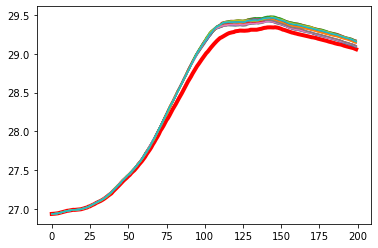

In [6]:
seed=87539319
plt.plot(run_model_gd(ticks=200, seed_bmi=seed, seed_graph=seed), color="red", lw=4)

for i in range(20):
    plt.plot(run_model_stocastic(ticks=200, seed_bmi=seed, seed_graph=seed))

Below is a similar experiment but comparing the uniform update FTA model to $20$ different stochastic FTA models with ten batches of ten agents. This has added back in a similar amount of model variance as we see with the original random serial model.

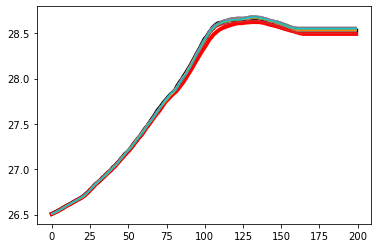

In [7]:
seed=42
plt.plot(run_model_stocastic(ticks=200, seed_bmi=seed, seed_graph=seed), color="black", lw=4)
plt.plot(run_model_gd(ticks=200, seed_bmi=seed, seed_graph=seed), color="red", lw=4)

for i in range(20):
    plt.plot(run_model(ticks=200, seed_bmi=seed, seed_graph=seed, n_minibatch=10))

Even with larger batches (of $25$ agents) the batch updates are very close to the stochastic model!

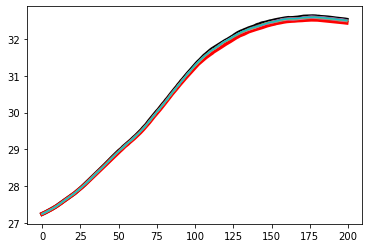

In [8]:
seed=12349876
plt.plot(run_model_stocastic(ticks=200, seed_bmi=seed, seed_graph=seed), color="black", lw=4)
plt.plot(run_model_gd(ticks=200, seed_bmi=seed, seed_graph=seed), color="red", lw=4)

for i in range(20):
    plt.plot(run_model(ticks=200, seed_bmi=seed, seed_graph=seed, n_minibatch=4))

# Faster Code
## JIT Speed UP

Now let's use the [Numba library](https://numba.pydata.org/numba-doc/dev/user/5minguide.html) to increase the performance of our best models. This will require rewritting some code but things can more or less stay the same because numba works well with numpy.

In [9]:
def fast_gd_model(ticks=200, n=100, rewire_prob=0.1, radius=0.1, alpha=3, beta=0.25, mean_degree=4, 
              seed_bmi=None, seed_graph=None):
    """
    A faster version of run_model_gd() using numba JIT
    """
    # Create graph network, numba cannot interact with nx so we will just include this in a
    # non njit wrapper function
    A = nx.to_numpy_array(nx.watts_strogatz_graph(n, mean_degree, rewire_prob, seed=seed_graph))
    return njit_gd(A, ticks=ticks, n=n, radius=radius, alpha=alpha, beta=beta, seed_bmi=seed_bmi)


@njit
def njit_gd(A, ticks=200, n=100, radius=0.1, alpha=3, beta=0.25, seed_bmi=None):
    """
    run_model_gd() code that JIT is applied to
    """
    # Numba does not support rng objects but we can stil set a seed
    if seed_bmi != None:
        np.random.seed(seed_bmi)
    
    # The following is identical to the code above
    b = 15 + np.random.gamma(alpha, 1/beta, n)
    mean_bmi = np.zeros(ticks)
    A = (A / np.sum(A, axis=1)) - np.identity(n)
    
    for i in range(ticks):
        mean_bmi[i] = np.mean(b)
        delta = b @ A
        # We will need to use np.abs here but otherwise is the same
        b += np.where(np.abs(delta) < radius, 0, np.sign(delta)*np.minimum(np.abs(delta), 0.1))
        
    return mean_bmi

In [10]:
# Run the model once before benchmarking it
fast_gd_model();

In [11]:
%%timeit
fast_gd_model()

2.29 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
def fast_sctocastic_model(ticks=200, n=100, rewire_prob=0.1, radius=0.1, alpha=3, beta=0.25, mean_degree=4, 
              seed_bmi=None, seed_graph=None, bmi=None):
    """
    A faster version of run_model_sctocastic() using numba JIT
    """
    #print(bmi[:5])
    A = nx.to_numpy_array(nx.watts_strogatz_graph(n, mean_degree, rewire_prob, seed=seed_graph))
    return njit_stocastic(A, ticks=ticks, n=n, radius=radius, alpha=alpha, beta=beta, seed_bmi=seed_bmi, bmi=bmi)

@njit
def njit_stocastic(A, ticks=200, n=100, radius=0.1, alpha=3, beta=0.25, seed_bmi=None, bmi=None):
    """
    run_model_sctocastic() code that JIT is applied to
    """
    if seed_bmi != None:
        np.random.seed(seed_bmi)
        
    b = 15 + np.random.gamma(alpha, 1/beta, n)
    mean_bmi = np.zeros(ticks)
    indices = np.arange(n)
    
    # Adding a reshape operation here so dot products can be taken contiguously in memory.
    # !! This is important for performace, it reduces cache misses and allows for faster opperations 
    A = (A / np.sum(A, axis=0).reshape(n, 1)) - np.identity(n)
    
    for i in range(ticks):
        mean_bmi[i] = np.mean(b)
        random.shuffle(indices)
        
        for j in indices:
            # Switching to dot product for performance, see point above about contiguous memory
            delta = np.dot(A[j, :], b)
            
            if abs(delta) >= radius:
                b[j] += np.sign(delta)*min(abs(delta), 0.1)
            
    return mean_bmi

In [13]:
# Run the model once before benchmarking it
fast_sctocastic_model();

In [14]:
%%timeit
fast_sctocastic_model()

3.31 ms ± 613 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Multiprocessing

Now that we have our code running as fast as possible can we do better? Probably not on a single run *but* if we have to run a model many times we could split the work between multiple computer cores!

In [15]:
def base_model_run(n=100):
    for _ in range(n):
        fast_sctocastic_model()

In [16]:
%%timeit
base_model_run()

331 ms ± 9.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
def multi_model_run():
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Argument for each process (12/13 runs over 8 processes)
        args = np.array([12]*4 + [13]*4)
        
        # Run 100 models across two processes
        results = executor.map(base_model_run, args)

In [18]:
%%timeit
multi_model_run()

207 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It can take a bit of overhead to get each process up and runnning so the comparison is not a perfect division of time in this example. However for larger tasks the speed up should be better!

## Extra Time Tests

In [19]:
%%timeit
run_model_gd(200)

12.8 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%%timeit
run_model()

69.6 ms ± 7.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%%timeit
run_model_stocastic(200)

163 ms ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
run_model(n_minibatch=100)

1.13 s ± 308 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
